/home/hanikevi/.local/lib/python3.6/site-packages/ipykernel_launcher.py:76: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


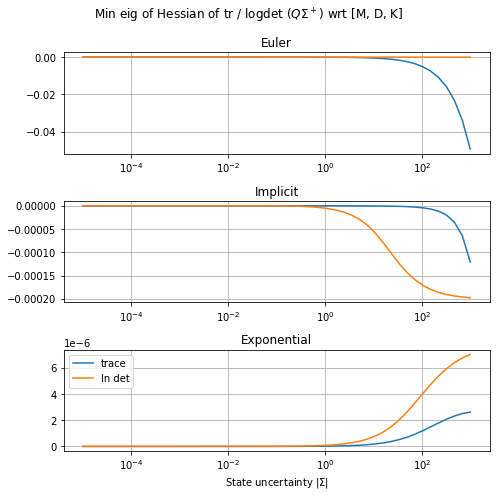

In [3]:
"""
Code to check the convexity of the GP-MPC problem; with special attention to impedance optimization
"""
import casadi as ca
import numpy as np
import matplotlib.pyplot as plt

def min_eig(A):
    evals, _ = np.linalg.eig(A)
    return np.min(evals)

M = ca.SX.sym('M')
D = ca.SX.sym('B')
K = ca.SX.sym('K')

h = 0.1

A_expl = ca.SX.eye(2)
A_expl[0,1] = h
A_expl[1,0] = -h*K/M
A_expl[1,1] = 1-h*D/M

A_impl = ca.SX.eye(2)
A_impl[0,1] = h
A_impl[1,0] = -h*K/M
A_impl[1,1] = D/(D+h*M)

A_solv = ca.SX.eye(2)
A_solv[0,1] = h
A_solv[1,0] = -h*K/M
A_solv[1,1] = ca.exp(-h*D/M)

As = [A_expl, A_impl, A_solv]
names = ['Euler', 'Implicit', 'Exponential']

B = ca.SX.zeros(2,1)
B[1,0] = -1/M

Sigma = ca.SX.sym('Sigma',2,2)

Sigma_f = ca.SX.sym('Sigma_f',1,1)
Q       = ca.DM([[1.0, 0],
                 [0,   1.0]])

fig, axs = plt.subplots(len(As), figsize=(7,7))

for A, name, i in zip(As, names, range(len(As))):
    Sigma_plus = A@Sigma@A.T + B@Sigma_f@B.T
    tr = ca.trace(Q@Sigma_plus)
    det = ca.log(ca.det(Q@Sigma_plus))
    dec_vars = [Sigma, Sigma_f, M, D, K]
    hess_vars = [M, D, K]
    
    ell_tr  = ca.Function('tr', dec_vars, [tr])
    ell_det = ca.Function('logdet', dec_vars, [det])
    
    hess_tr  = ca.Function('hess_tr',  dec_vars, [ca.hessian(tr,  ca.vertcat(*hess_vars))[0]])
    hess_det = ca.Function('hess_det', dec_vars, [ca.hessian(det, ca.vertcat(*hess_vars))[0]])

    hess_tr_num  = []
    hess_det_num = []
    weight = np.logspace(-5, 3, 50)
    for w in weight:
        dec_vars_num = [w*ca.DM.eye(2), 11.1, 10, 500, 0]
        
        hess_tr_num.append(min_eig(hess_tr(*dec_vars_num)))
        hess_det_num.append(min_eig(hess_det(*dec_vars_num)))
    axs[i].semilogx(weight, hess_tr_num, label='trace')
    axs[i].semilogx(weight, hess_det_num,label='ln det')
    axs[i].set_title(name)
    axs[i].grid(True)
axs[-1].legend()
axs[-1].set(xlabel='State uncertainty $|\Sigma|$')
fig.suptitle('Min eig of Hessian of tr / logdet ($Q\Sigma^+$) wrt [M, D, K]')
fig.tight_layout()
fig.show()
    
